#### Recurrent Neural Network with PyTorch 

#### Model Description
* Unroll 28 time steps
    * Each step input size : 28 X 1
    * Total per unroll : 28 X 28
        * Feedforward 
* 2 Hidden Layers
* Tan H Activation Function

In [7]:
#import
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [8]:
#load train dataset
train_dataset = dsets.MNIST(root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

In [9]:
len(train_dataset)

60000

In [10]:
type(train_dataset[0])

tuple

In [11]:
# Input Matrix
train_dataset[0][0].size()

torch.Size([1, 28, 28])

In [12]:
# Label
train_dataset[0][1]

5

In [13]:
#import
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [14]:
train_dataset[0][0].numpy().shape

(1, 28, 28)

In [15]:
show_img = train_dataset[0][0].numpy().reshape(28, 28)

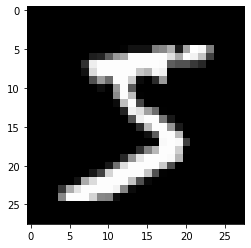

In [16]:
plt.imshow(show_img, cmap='gray')

In [17]:
# Label
train_dataset[0][1]

5

In [18]:
#Load test dataset
test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

In [19]:
len(test_dataset)

10000

In [20]:
type(test_dataset[0])

tuple

In [21]:
# Image Matrix
test_dataset[0][0].size()

torch.Size([1, 28, 28])

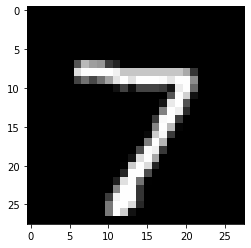

In [22]:
show_img = test_dataset[0][0].numpy().reshape(28, 28)
plt.imshow(show_img, cmap='gray')

In [23]:
# Label
test_dataset[0][1]

7

In [24]:
print(train_dataset.train_data.size())

torch.Size([60000, 28, 28])


C:\Users\Kunal\Anaconda3\envs\gputest\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [25]:
print(train_dataset.train_labels.size())

torch.Size([60000])


C:\Users\Kunal\Anaconda3\envs\gputest\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [26]:
print(test_dataset.test_data.size())

torch.Size([10000, 28, 28])


C:\Users\Kunal\Anaconda3\envs\gputest\lib\site-packages\torchvision\datasets\mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [27]:
print(test_dataset.test_labels.size())

torch.Size([10000])


C:\Users\Kunal\Anaconda3\envs\gputest\lib\site-packages\torchvision\datasets\mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


#### Make Dataset Iterable

* totaldata : 60000
* minibatch : 100
    * Number of examples in 1 iteration
* iterations : 3000
    * 1 iteration : one mini batch forward & backward pass
* epochs
    * 1 epoch : running through the whole dataset once
    * total : (iterations * minibatch) / totaldata = 5

In [28]:
len(train_dataset)

60000

In [29]:
batch_size = 100
n_iters = 3000

In [30]:
num_epochs = (n_iters * batch_size) / len(train_dataset)
num_epochs = int(num_epochs)
num_epochs

5

In [31]:
#Create Iterable Object : Training Dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=True)

In [32]:
#Check Iterability
import collections
isinstance(train_loader, collections.Iterable)

C:\Users\Kunal\Anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  This is separate from the ipykernel package so we can avoid doing imports until


True

In [33]:
#Create Iterable Object : Testing Dataset
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=batch_size,
                                           shuffle=False)

In [34]:
import collections
isinstance(test_loader, collections.Iterable)

True

In [35]:
# for i, (img, l) in enumerate(train_loader):
#     check = img.view(-1,28)
#     print(check.size())
#     break

#### Building Model

In [36]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Hidden Dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # Building your RNN
        # batch_first = True causes input/outputs to be of shape
        # (batch_dim, seq_dim, input_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='tanh')
        
        # Linear function (readout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)

        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
        # One time step
        out, hn = self.rnn(x, h0)
        
        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want the last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        
        return out

In [37]:
#Define Layers
input_dim = 28
hidden_dim = 100
layer_dim = 2 # Number of RNN layers
output_dim = 10

In [38]:
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

In [39]:
if torch.cuda.is_available():
    model.cuda()

In [40]:
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

RNNModel(
  (rnn): RNN(28, 100, num_layers=2, batch_first=True)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)
10
torch.Size([100, 28])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [41]:
# FFN has cross entropy loss (similar to logistic but linear regression has MSE)
criterion = nn.CrossEntropyLoss()

#### Optimizer Class

In [42]:
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [43]:
print(model.parameters())

print(len(list(model.parameters())))

print(list(model.parameters())[0].size())

print(list(model.parameters())[1].size())

print(list(model.parameters())[2].size())

print(list(model.parameters())[3].size())

print(list(model.parameters())[4].size())

print(list(model.parameters())[5].size())

<generator object Module.parameters at 0x000001B668557BC8>
10
torch.Size([100, 28])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100, 100])


#### Train Model

In [45]:
# Number of steps to unroll
seq_dim = 28

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
#         Load images as Variable
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, seq_dim, input_dim))
            labels = Variable(labels)
    
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
    
        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss : softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            
            # Iterate through test dataset
            for images, labels in test_loader:
                # Load images as Variable
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, seq_dim, input_dim).cuda())
                else:
                    images = Variable(images.view(-1, seq_dim, input_dim))

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() # as predicted is on cpu, get everything to cpu
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data.item(), accuracy))

Iteration: 500. Loss: 0.5302202105522156. Accuracy: 85
Iteration: 1000. Loss: 0.18384239077568054. Accuracy: 92
Iteration: 1500. Loss: 0.4414994418621063. Accuracy: 91
Iteration: 2000. Loss: 0.11302641034126282. Accuracy: 95
Iteration: 2500. Loss: 0.15649831295013428. Accuracy: 95
Iteration: 3000. Loss: 0.11812660098075867. Accuracy: 95


In [46]:
save_model = False
if save_model is True:
    # Save only parameters
    torch.save(model.state_dict(), "rnn.pkl")